This is chapter 3 of the book by Aurelien Geron.

# Fetching and loading dataset from MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
X, y = mnist.data, mnist.target

# Necessary imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(suppress=True,linewidth=sys.maxsize,threshold=sys.maxsize)

# Visualizing data

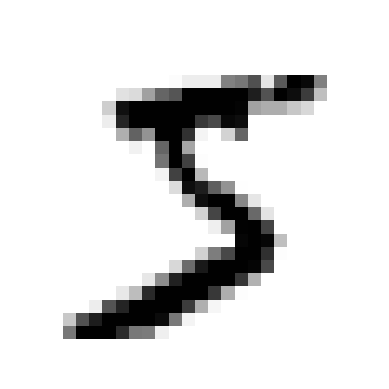

In [103]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
plt.show()

# Splitting data

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a '5 detector'

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
sgd_class = SGDClassifier(random_state = 42)
sgd_class.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
cross_val_score(sgd_class, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
dummy_class = DummyClassifier()
dummy_class.fit(X_train, y_train_5)

DummyClassifier()

In [12]:
cross_val_score(dummy_class, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

# Implementing Cross-Validation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
skfolds = StratifiedKFold(n_splits = 3) # add shuffle = True if the data is not shuffled
for train_index, val_index in skfolds.split(X_train, y_train_5):
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_val_folds = X_train[val_index]
    y_val_folds = y_train_5[val_index]

    cloned = clone(sgd_class)

    cloned.fit(X_train_folds, y_train_folds)
    predicted = cloned.predict(X_val_folds)
    correct = sum(predicted == y_val_folds)
    print(correct / len(predicted))

0.95035
0.96035
0.9604


# Confusion Matrix, Precision and Recall

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y_train_5, y_train_pred)) # TP / (TP + FP) ie. 3530 / (3530 + 687)
print("Recall:    ", recall_score(y_train_5, y_train_pred))    # TP / (TP + FN) ie. 3530 / (3530 + 1891)
print("f1 score:  ", f1_score(y_train_5, y_train_pred))

Precision:  0.8370879772350012
Recall:     0.6511713705958311
f1 score:   0.7325171197343847


### Precision/Recall Trade-Off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold,it assigns the instance to the positive class; otherwise it assigns it to the negative class. <br>
The  SGDClassifier  uses  a  threshold  equal  to  0

In [18]:
# Getting scores

y_scores = sgd_class.decision_function(X_train)

y_scores = cross_val_predict(sgd_class, X_train, y_train_5, cv = 3, method='decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds_pr = precision_recall_curve(y_train_5, y_scores)

In [20]:
id_90p_pr = (precisions > 0.9).argmax()

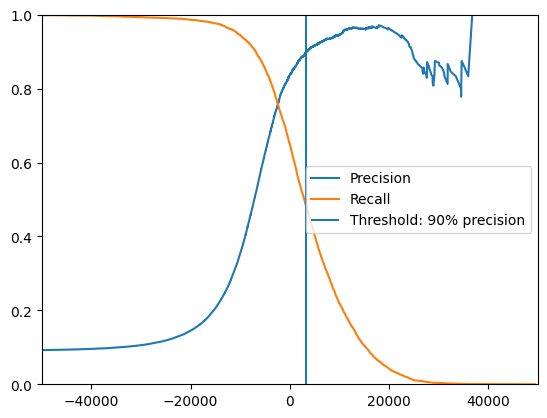

In [21]:
plt.plot(thresholds_pr, precisions[:-1], label = 'Precision') # function adds a last precision of 0
plt.plot(thresholds_pr, recalls[:-1], label = 'Recall') # function adds a last recall of 1
plt.vlines(thresholds_pr[id_90p_pr], ymin=0, ymax=1, label= 'Threshold: 90% precision')
plt.axis([-50000, 50000, 0, 1])
plt.legend()

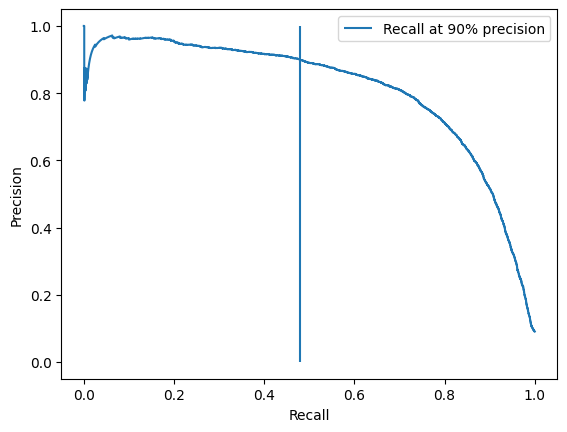

In [22]:
plt.plot(recalls, precisions)
plt.vlines(recalls[id_90p_pr], 0, 1, label='Recall at 90% precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# ROC Curve

ROC curve plots the true positive rate (TPR) against the false positive rate (FPR). <br><br>

True positive rate (recall or sensitivity): Ration of positive instances that are correctly classified as postive.<br>
False positive rate (fall-out): Ratio of negative instances that are incorrectly classified as positive. Equates to 1 - specifity<br>
True negative rate (specifity): Ratio of negative instances that are correctly classified as negative<br>
False negative rate (FNR).  Ratio of positive instances that are incorrectly classified as negative. <br><br>

Hence ROC plots sensitivity versus 1 - specifity.

In [23]:
from sklearn.metrics import roc_curve

In [24]:
fpr, tpr, thresholds_roc = roc_curve(y_train_5, y_scores)

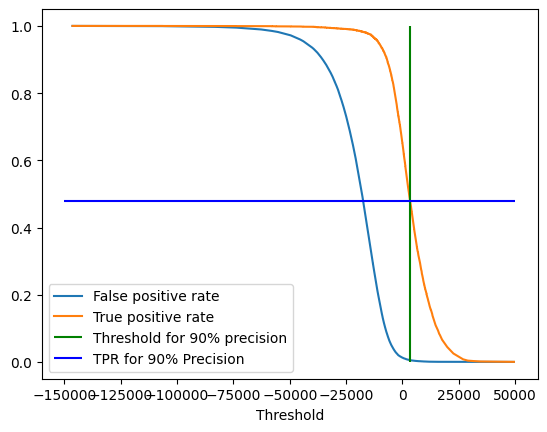

In [25]:
plt.plot(thresholds_roc, fpr, label = 'False positive rate') 
plt.plot(thresholds_roc, tpr, label = 'True positive rate') 
plt.xlabel('Threshold')
plt.vlines(thresholds_pr[id_90p_pr], 0, 1, label='Threshold for 90% precision', colors= 'g')
plt.hlines(recalls[id_90p_pr], -150000, 50000, label = 'TPR for 90% Precision', colors='b')
plt.legend()

In [26]:
id_90p_roc = (thresholds_roc >= (thresholds_pr[id_90p_pr])).argmin()

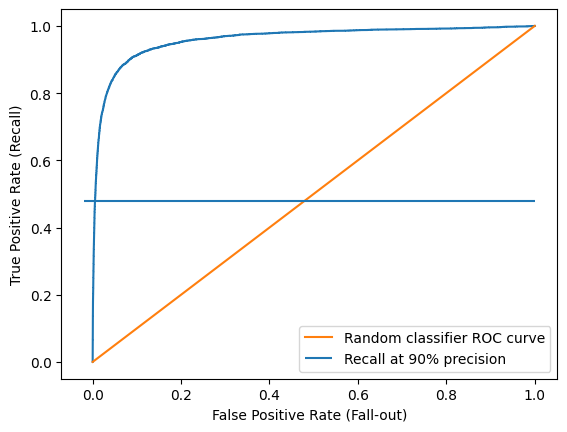

In [27]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (Fall-out)')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1],[0,1], label = 'Random classifier ROC curve')
plt.hlines(tpr[id_90p_roc], -0.02, 1, label='Recall at 90% precision')
plt.legend()


In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

### PR-curve and F1-score comparison: SGD Classifier and Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [30]:
y_probas = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method='predict_proba')

In [31]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_probas[:,1])

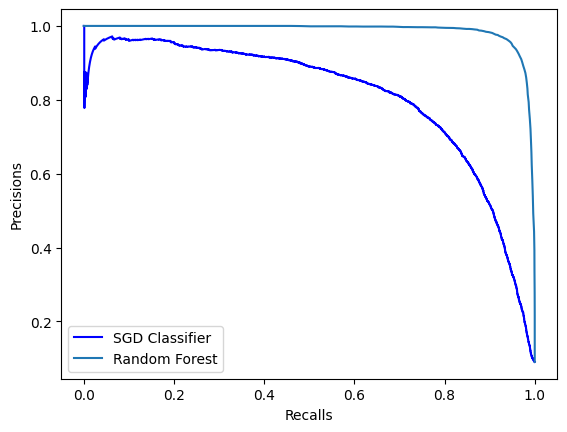

In [32]:
plt.plot(recalls, precisions, 'b-', label = 'SGD Classifier')
plt.plot(recalls_forest, precisions_forest, label = 'Random Forest')
plt.xlabel('Recalls')
plt.ylabel('Precisions')
plt.legend()

In [33]:
y_forest_pred = (y_probas[:,-1] >= 0.5)
f1_score(y_train_5, y_forest_pred)
roc_auc_score(y_train_5, y_probas[:,1])

np.float64(0.9983436731328145)

# Multiclass Classification: SVM and SGD

### Support Vector Machine

In [34]:
from sklearn.svm import SVC

svm_class = SVC(random_state=42)
svm_class.fit(X_train, y_train)

SVC(random_state=42)

In [35]:
svm_class.predict([X_train[0]])
svm_class.decision_function([X_train[0]]).round(2)

array([[ 1.73,  2.73,  7.25,  8.31, -0.31,  9.31,  1.71,  2.77,  6.23,  4.85]])

In [36]:
svm_class.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [37]:
svm_class.classes_[5]

'5'

Scikit Learn automatically used OvO strategy with the Support Vector Machine Classifier. However, if you want to use ovo or ovr you can use their respective classes.

In [38]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [39]:
ovr = OneVsRestClassifier(SVC(random_state=42))

ovr.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [40]:
ovr.predict([X_train[0]])

array(['5'], dtype='<U1')

OneVsRestClassifier built 10 binary classifier, one for each digit.

In [41]:
ovr.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

### Stochastic Gradient Descent

In [42]:
sgd_class = SGDClassifier(random_state=42)

sgd_class.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [43]:
sgd_class.predict([X_train[0]])

array(['3'], dtype='<U1')

In [44]:
sgd_class.decision_function([X_train[0]]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189., -16148.,  -4604., -12051.]])

In [45]:
cross_val_score(sgd_class, X_train, y_train, cv = 3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_class, X_train_scaled, y_train, cv = 3, scoring= 'accuracy')

array([0.8983, 0.891 , 0.9018])

### Doing Error Analysis on SGD Classifier

In [48]:
y_pred = cross_val_predict(sgd_class, X_train_scaled, y_train, cv = 3)

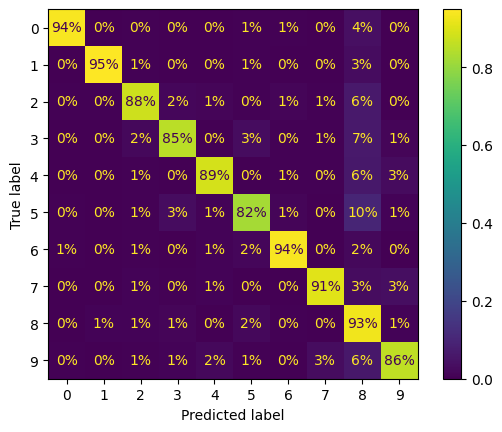

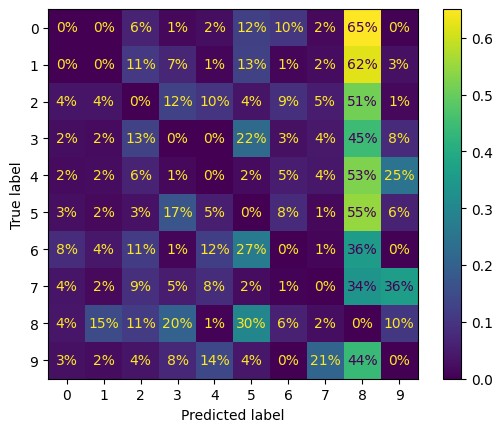

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

#ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize='true', values_format='.0%') # normalize to true normalizes by rows
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize='true', values_format='.0%', sample_weight=(y_train != y_pred)) # change normalize to pred to have errors normalized by columns

In [74]:
fivet_fivep = X_train[(y_train == '5') & (y_pred == '5')]

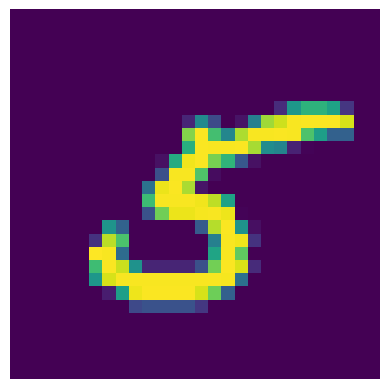

In [78]:
plot_digit(fivet_fivep[6])

# Multilabel Classification

In [82]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_multilabel = np.c_[(y_train >= '7'), (y_train.astype('int8') % 2 == 1)]

In [85]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)

KNeighborsClassifier()

In [87]:
print(knn_clf.predict([X_train[0]]), y_train[0])

[[False  True]] 5


In [88]:
y_multilabel_predict = cross_val_predict(knn_clf, X_train, y_train_multilabel, cv = 3)

In [90]:
f1_score(y_train_multilabel, y_multilabel_predict, average='macro') # compute f1_score for each label

# use average = 'weighted' so that each label gets a weight equal to its support ie. number of instances with that target label

np.float64(0.9764102655606048)

### Using classifier that does not natively support multi-label classification

In [91]:
from sklearn.multioutput import ClassifierChain

In [92]:
chain_clf = ClassifierChain(SVC(), cv = 3, random_state=42)
chain_clf.fit(X_train[:2000], y_train_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [93]:
chain_clf.predict([X_train[0]])

array([[0., 1.]])

# Multiclass-Multilabel Classification

In [100]:
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test


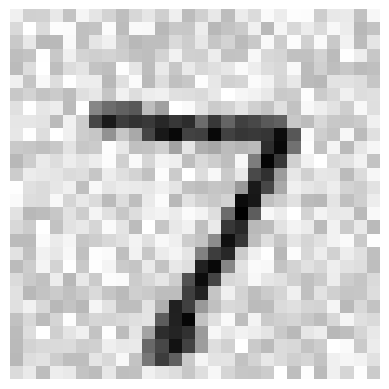

In [105]:
plot_digit(X_test_mod[0])

In [107]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

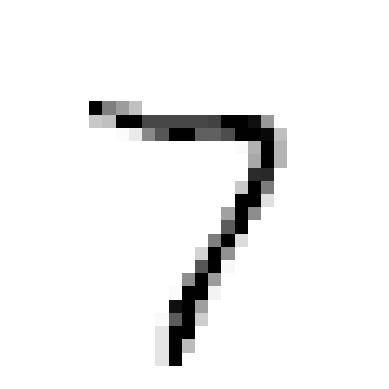

In [108]:
plot_digit(knn_clf.predict([X_test_mod[0]]))